# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']



import pyaldata as pyal
from defs import *

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(params)
finally:
    os.chdir(nbPath)

# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

## within mice, within area, within epoch, targets matched, subset of trials

In [3]:
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)

allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)


AllData1 = dt.get_data_array(allDFs_M1, exec_epoch, area=areas[0], model=n_components)
AllData2 = dt.get_data_array(allDFs_Str, exec_epoch, area=areas[1], model=n_components)


warnings.filterwarnings("default")

In [4]:
n_iter = 1000
n_shared_trial1 = AllData1.shape[2]
n_shared_trial2 = AllData2.shape[2]
rng = np.random.default_rng(12345)
trialList1 = np.arange(n_shared_trial1)
trialList2 = np.arange(n_shared_trial2)


CCs1=[]
for sessionData in AllData1:
    r = []
    for n in range(n_iter):
        rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
        r.append(dt.canoncorr(data1, data2))
    CCs1.append(r)
CCs1 = np.array(CCs1)
CC_upper_bound_M1 = np.percentile(CCs1, 99, axis=1).T

CCs2=[]
for sessionData in AllData2:
    r = []
    for n in range(n_iter):
        rng.shuffle(trialList2)
        # non-overlapping randomised trials
        trial1 = trialList2[:n_shared_trial2//2]
        trial2 = trialList2[-(n_shared_trial2//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
        r.append(dt.canoncorr(data1, data2))
    CCs2.append(r)
CCs2 = np.array(CCs2)
CC_upper_bound_Str = np.percentile(CCs2, 99, axis=1).T

if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
    print('variables: `CC_upper_bound_M1` and `CC_upper_bound_Str` hold the upper bound correlations')

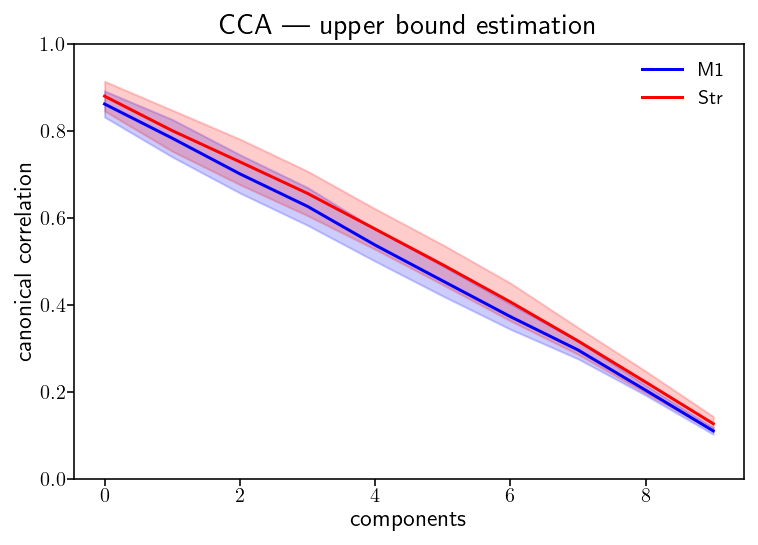

In [6]:
if "__file__" not in dir():
    _,ax = plt.subplots()
    M1_Lines,_ = utility.shaded_errorbar(ax, CC_upper_bound_M1, color='b', label='M1')
    Str_lines,_ = utility.shaded_errorbar(ax, CC_upper_bound_Str, color='r', label='Str')

    plt.legend(handles=[M1_Lines, Str_lines])
    plt.ylim([0,1])
    plt.xlabel('components')
    plt.ylabel('canonical correlation')
    plt.title('CCA --- upper bound estimation');